In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
def print_error_matrix(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    precision=  tp / (tp+fp)if (tp+fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    F1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    print(f"Accuracy:     {accuracy:.4f}")
    print(f"F1:           {F1:.4f}")
    print(f"Precision:    {precision:.4f}")
    print(f"Sensitivity:  {sensitivity:.4f}")
    print(f"Specificity:  {specificity:.4f}")
    print(f"TP:           {tp}")
    print(f"FP:           {fp}")
    print(f"TN:           {tn}")
    print(f"FN:           {fn}")
    print("         Pred 0    Pred 1")
    print(f"True 0    {tn:4}     {fp:4}")
    print(f"True 1    {fn:4}     {tp:4}")

def test_model(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_val)
    
    tn, fp, fn, tp =confusion_matrix(y_val, y_pred).ravel()
    
    F1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    return F1
    

In [3]:
train=pd.read_csv("dataset_train.csv")
test=pd.read_csv("dataset_test.csv")

test['arrytmia'] = test['arrytmia'].apply(lambda x: 1 if x > 1 else x)
train['arrytmia'] = train['arrytmia'].apply(lambda x: 1 if x > 1 else x)


scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

test = pd.DataFrame(scaler.transform(test), columns=test.columns)



X_train = train.iloc[: ,1:].values
y_train = train['arrytmia'].values

X_test = test.iloc[: ,1:].values
y_test = test['arrytmia'].values

In [4]:
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## KNN

In [5]:
n_trials=20

In [6]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 200) # Liczba sąsiadów
    weights = trial.suggest_categorical('weights', ['uniform', 'distance']) #Sposób ważenia sąsiadów
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    metric=trial.suggest_categorical('metric',['euclidean','manhattan'])
    
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        metric=metric,
        n_jobs=-1
    )


    return test_model(model)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params
print("Najlepsze parametry:", best_params)

[I 2025-07-16 11:13:27,838] A new study created in memory with name: no-name-14fec4d0-29d7-4e56-8bd6-7bb298b987a6
[I 2025-07-16 11:13:29,114] Trial 0 finished with value: 0.9245569620253165 and parameters: {'n_neighbors': 195, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9245569620253165.
[I 2025-07-16 11:13:30,197] Trial 1 finished with value: 0.9407053750192516 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9407053750192516.
[I 2025-07-16 11:13:31,900] Trial 2 finished with value: 0.9286657859973579 and parameters: {'n_neighbors': 140, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9407053750192516.
[I 2025-07-16 11:13:32,890] Trial 3 finished with value: 1.0 and parameters: {'n_neighbors': 197, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean'}. Best is trial 3 with value: 1.0.

Najlepsze parametry: {'n_neighbors': 197, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean'}


In [7]:
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print_error_matrix(y_test,y_pred)

Accuracy:     0.7823
F1:           0.8740
Precision:    0.7801
Sensitivity:  0.9935
Specificity:  0.1137
TP:           4920
FP:           1387
TN:           178
FN:           32
         Pred 0    Pred 1
True 0     178     1387
True 1      32     4920


## DecisionTree

In [8]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy','log_loss']) 
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 3, 20) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    #DODAJ CCP_ALPHA

    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        splitter=splitter,
        random_state=42
    )


    return test_model(model)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params
print("Najlepsze parametry:", best_params)

[I 2025-07-16 11:13:57,261] A new study created in memory with name: no-name-6cb86c0f-8454-4969-bc5a-b9b0896fcf30
[I 2025-07-16 11:13:57,281] Trial 0 finished with value: 0.852773826458037 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.852773826458037.
[I 2025-07-16 11:13:59,022] Trial 1 finished with value: 0.9460771519548989 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.9460771519548989.
[I 2025-07-16 11:14:00,667] Trial 2 finished with value: 0.9505683595786839 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 2 with value: 0.9505683595786839.
[I 2025-07-16 11:14:00,702] Trial 3 finished with value: 0.869670660

Najlepsze parametry: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}


In [9]:
best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print_error_matrix(y_test,y_pred)

Accuracy:     0.5753
F1:           0.6848
Precision:    0.7851
Sensitivity:  0.6072
Specificity:  0.4741
TP:           3007
FP:           823
TN:           742
FN:           1945
         Pred 0    Pred 1
True 0     742      823
True 1    1945     3007


## RandomForestClassifier

In [10]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200) # liczba drzew w lesie
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 5, 50) # Maksymalna głebokość drzewa
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) # Minimalna liczba próbek w węźle wymagana do podzielenia
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20) # minimalna liczba próbek w liściu
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2']) # Liczba cech rozważanych podczas rodzielania węzła
    
    model = RandomForestClassifier(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    
    score = cross_val_score(model, X_val, y_val, cv=5, scoring='f1').mean()
    return score 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params
print("Najlepsze parametry:", best_params)


[I 2025-07-16 11:14:05,313] A new study created in memory with name: no-name-3bf70a60-b7d2-42cb-91ed-f4d89ef096e0
[I 2025-07-16 11:14:17,561] Trial 0 finished with value: 0.9361818813275977 and parameters: {'n_estimators': 91, 'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9361818813275977.
[I 2025-07-16 11:14:40,554] Trial 1 finished with value: 0.9355880201199531 and parameters: {'n_estimators': 144, 'criterion': 'log_loss', 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9361818813275977.
[I 2025-07-16 11:14:54,776] Trial 2 finished with value: 0.9344205670421971 and parameters: {'n_estimators': 138, 'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.9361818813275977.
[I 2025-07-16 11:15:12,281] Trial 3 finished with value: 0.9333836

Najlepsze parametry: {'n_estimators': 73, 'criterion': 'entropy', 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}


In [11]:
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print_error_matrix(y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.46      0.25      0.32      1565
         1.0       0.79      0.91      0.85      4952

    accuracy                           0.75      6517
   macro avg       0.63      0.58      0.58      6517
weighted avg       0.71      0.75      0.72      6517

Accuracy:     0.7491
F1:           0.8462
Precision:    0.7921
Sensitivity:  0.9081
Specificity:  0.2460
TP:           4497
FP:           1180
TN:           385
FN:           455
         Pred 0    Pred 1
True 0     385     1180
True 1     455     4497


## SVM

In [ ]:
from sklearn.preprocessing import StandardScaler

# Wczytanie danych
train = pd.read_csv("dataset_train.csv")
test = pd.read_csv("dataset_test.csv")

# Przekształcenie kolumny 'arrytmia'
test['arrytmia'] = test['arrytmia'].apply(lambda x: 1 if x > 1 else x)
train['arrytmia'] = train['arrytmia'].apply(lambda x: 1 if x > 1 else x)

test['arrytmia'] = test['arrytmia'].apply(lambda x: -1 if x == 0 else x)
train['arrytmia'] = train['arrytmia'].apply(lambda x: -1 if x == 0 else x)

# Przygotowanie danych
X_train = train.iloc[:, 1:]  # zakładam, że pierwsza kolumna to np. indeks/czas
y_train = train['arrytmia'].values

X_test = test.iloc[:, 1:]
y_test = test['arrytmia'].values

# Normalizacja
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [12]:
def objective(trial):
    C = trial.suggest_float('C', 1e-5, 1e5,log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
        coef0 = trial.suggest_float ('coef0', -1, 1)
        model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0, random_state=42)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    
    
    score = cross_val_score(model, X_val, y_val, cv=5, scoring='f1').mean()
    return score 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params
print("Najlepsze parametry:", best_params)


[I 2025-07-16 11:19:22,110] A new study created in memory with name: no-name-4cd17899-4dd4-4b0a-a9ad-61f9e9b499f3
[I 2025-07-16 11:19:28,477] Trial 0 finished with value: 0.853188030537361 and parameters: {'C': 0.01547506364651005, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.853188030537361.
[I 2025-07-16 11:19:39,076] Trial 1 finished with value: 0.8517649141557048 and parameters: {'C': 0.0015775671125333732, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.853188030537361.
[I 2025-07-16 11:19:46,237] Trial 2 finished with value: 0.731486853427713 and parameters: {'C': 7174.277706667908, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.853188030537361.
[I 2025-07-16 11:20:35,026] Trial 3 finished with value: 0.9059298976056105 and parameters: {'C': 2084.653923350255, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.9059298976056105.
[I 2025-07-16 11:20:48,427] Trial 4 finished with value: 0.899829657269

KeyboardInterrupt: 

              precision    recall  f1-score   support

         0.0       0.89      0.57      0.69      1856
         1.0       0.72      0.94      0.82      2257

    accuracy                           0.77      4113
   macro avg       0.81      0.75      0.75      4113
weighted avg       0.80      0.77      0.76      4113



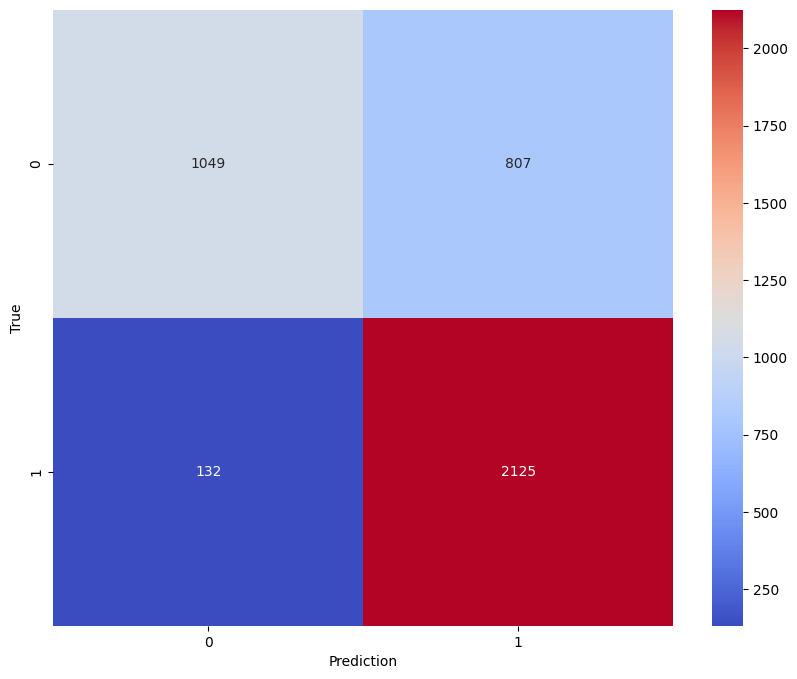

In [ ]:
best_model = SVC(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print_error_matrix(y_test,y_pred)